# A/B Testing Protocol

In [20]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
#Our results from A/B test for click-throughs
A_views, A_clicks = 2745, 1958
B_views, B_clicks = 759, 523

In [21]:
# Need to update the model in context
# Using a Beta-Binomial distribution to model success vs. failure
with pm.Model():
    
    # Define our guess on what the clicktrough might be. This is a ratio of success:failure (alpha:beta). 
    # It is ok for this to be uninformative (1:1) but is able to capture our assumptions.
    p_A = pm.Beta('p_A', alpha=3, beta=1)
    p_B = pm.Beta('p_B', alpha=3, beta=1)
    
    # Update the model with the observations from the experiment
    obs_A = pm.Binomial('like_A', n=A_views, p=p_A, observed=A_clicks)
    obs_B = pm.Binomial('like_B', n=B_views, p=p_B, observed=B_clicks)
    
    # Examine the lift by subtracting B from A (how much better/worse is B than A)
    pm.Deterministic('difference', p_B - p_A)
    pm.Deterministic('relation', (p_B/p_A)-1)
    
    # This starts the MCMC procedure for generating outcomes where we do draws of N.
    trace = pm.sample(draws=5000, start=pm.find_MAP(), progressbar=True)

logp = -23.227, ||grad|| = 110.2: 100%|█████████████████████████████████████████████████| 9/9 [00:00<00:00, 359.03it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_B, p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 11000/11000 [01:00<00:00, 180.60draws/s]


                mean   hpd_2.5  hpd_97.5
p_A         0.713365  0.696509  0.729661
p_B         0.689768  0.657360  0.721288
difference -0.023597 -0.060048  0.012952
relation   -0.032941 -0.082752  0.018882


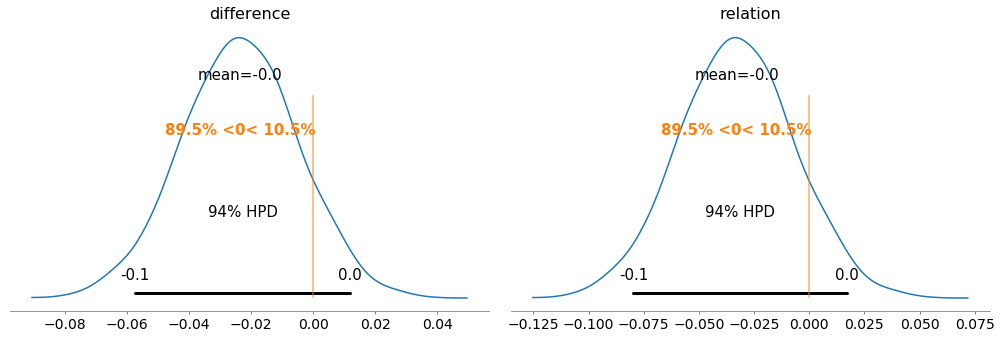

In [22]:
    
# We are interested in the posterior probability, so want to discard the first bunch of drows.    
#_ = pm.traceplot(trace[500:])

# Plot the lift of B over A
#Use the reference value to show relation to that value. Set to 0 for now show the hpd will indicate probablity
#that lift is better or worse than 0.
_ = pm.plot_posterior(trace[500:], varnames=['difference', 'relation'], ref_val=0, color='#87ceeb')

#pm.forestplot(trace)  #Uncomment to run a forest plot

# Discrete descriptions of the results. 
#The Rhat stat helps us be sure we are drawing from the posterior, should be close to 1
summary = pm.summary(trace)
print(summary[['mean','hpd_2.5','hpd_97.5']])

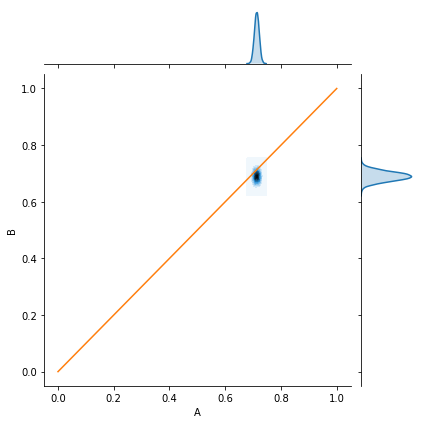

In [13]:
#Joint Posterior
pA = trace[1000:]['prior_A']
pB = trace[1000:]['prior_B']
delta_posterior = trace[1000:]['difference']

# 3d plot
vals=np.vstack([pA, pB]).T
limit=1.0
df=pd.DataFrame(vals, columns=['A', 'B'])
df=df[df['A']<limit]
df=df[df['B']<limit]
g=sns.jointplot(x=df.A, y=df.B, kind='kde', n_levels=15)
g.ax_joint.plot([0.0, limit], [0.0, limit])